# Model 3: Transfer Learning VGG16

This is built by adding multiple fully connected output layers and retraining the last Convolution Layer in Convolutional Block 5 with vehicle image dataset using a technique called transfer learning. 

In [7]:
### Installing the package required to import functions from notebooks
#!pip install import-ipynb

In [8]:
import import_ipynb
import os
from google.colab import files
files.upload()
os.chdir("/content/drive/MyDrive/Capstone Benchmark Models")

### We will import all the data_preparation functions
from  data_preparation import *


### We will import all visualization functions
from  plots import *

Saving kaggle.json to kaggle (1).json
importing Jupyter notebook from data_preparation.ipynb


Saving kaggle.json to kaggle (7).json
importing Jupyter notebook from plots.ipynb


In [18]:
### Importing necessary libraries

%matplotlib inline


from keras.models import Sequential,Model
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras import datasets, layers


## Preparing the Training and Test DataSet

In [10]:
### Dataset is downloaded
download_kaggle()

 99% 201M/203M [00:13<00:00, 24.1MB/s]
100% 203M/203M [00:13<00:00, 15.8MB/s]


In [11]:
### Images are extracted
image_files=image_extract()


In [12]:
### Preparing independent X
X=image_preprocessing_step(image_files,"transfer_vgg16")

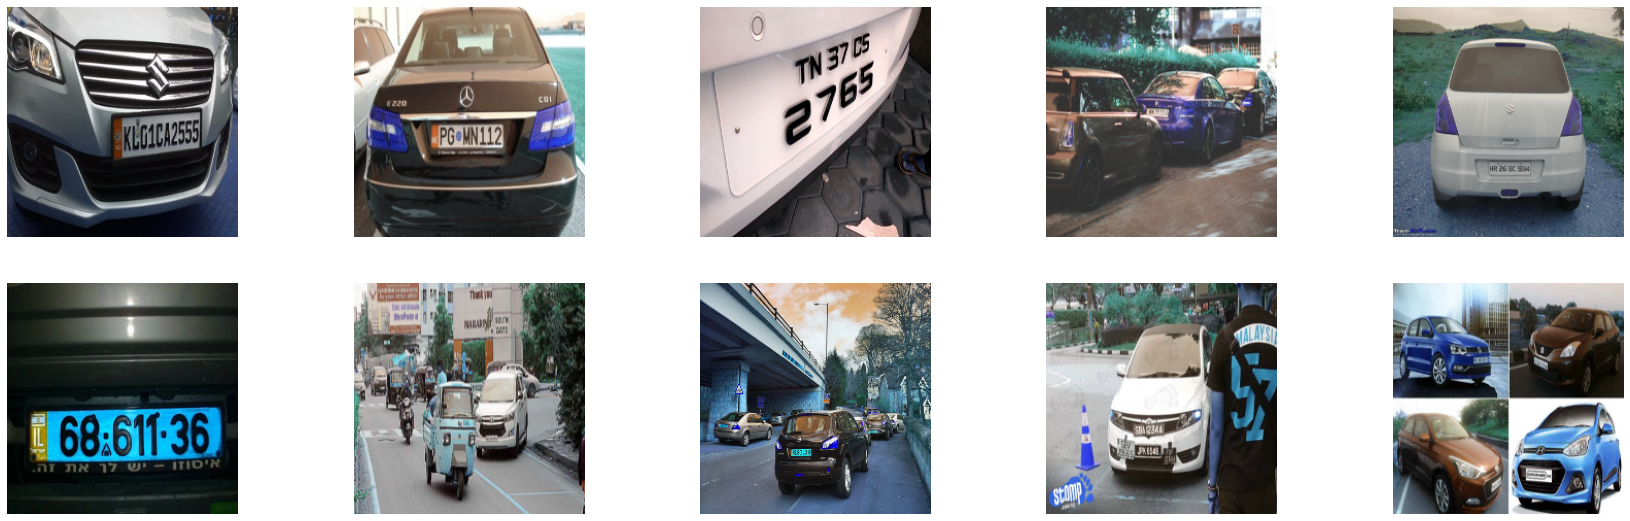

In [13]:
### Showing first 10 images
images_show(10,X)

In [14]:
### Getting a list annotations file

annotations_files=annotations_extract()

In [15]:
### Extracting boundaries from annotations

y=boundary_extract(annotations_files)

In [16]:
### Test train prepartion for 90/10 split
X_train, X_val, y_train, y_val,X_test,y_test=train_test(X,y)


### Model

In [19]:
# Create the model
# We are building a transfer learning based VGG16 model for regression to predict the boundaries of the license plate
# The model has been tuned to optimise MSE

vgg=VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

### All layers except the last convolution layer is frozen
for layer in vgg.layers[:17]:
    layer.trainable = False

for i, layer in enumerate(vgg.layers):
    print(i, layer.name, layer.trainable)


x=Flatten()(vgg.output)
x=Dense(128, activation="relu")(x)
x=Dense(128, activation="relu")(x)
x=Dense(64, activation="relu")(x)
x=Dense(32, activation="relu")(x)
x=Dense(16, activation="relu")(x)
x=Dense(4,activation="sigmoid")(x)

model=Model(inputs=vgg.input,outputs=x)



model.summary()

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0     

In [20]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam

checkpoint = ModelCheckpoint('my_model.h5', monitor= 'mse', mode= 'min', save_best_only = True, verbose= 1)
lr_reduce = ReduceLROnPlateau(monitor='mse', factor=0.6, patience=8, verbose=1, mode='min', min_lr=5e-5)

### We are using mean squared error loss function
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['MeanAbsoluteError','mse'])

In [21]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
10/10 [==============================] - 16s 540ms/step - loss: 0.0296 - mean_absolute_error: 0.1344 - mse: 0.0296 - val_loss: 0.0202 - val_mean_absolute_error: 0.1020 - val_mse: 0.0202
Epoch 2/50
10/10 [==============================] - 2s 181ms/step - loss: 0.0153 - mean_absolute_error: 0.0936 - mse: 0.0153 - val_loss: 0.0166 - val_mean_absolute_error: 0.0889 - val_mse: 0.0166
Epoch 3/50
10/10 [==============================] - 2s 181ms/step - loss: 0.0109 - mean_absolute_error: 0.0754 - mse: 0.0109 - val_loss: 0.0150 - val_mean_absolute_error: 0.0796 - val_mse: 0.0150
Epoch 4/50
10/10 [==============================] - 2s 181ms/step - loss: 0.0077 - mean_absolute_error: 0.0612 - mse: 0.0077 - val_loss: 0.0141 - val_mean_absolute_error: 0.0744 - val_mse: 0.0141
Epoch 5/50
10/10 [==============================] - 2s 181ms/step - loss: 0.0055 - mean_absolute_error: 0.0528 - mse: 0.0055 - val_loss: 0.0159 - val_mean_absolute_error: 0.0742 - val_mse: 0.0159
Epoch 6/50
10/10 [=

In [22]:
### Saving the model
model.save('transfer_learning_vgg16_model.h5', overwrite=True) 


In [23]:
# Validation dataset performance
scores = model.evaluate(X_test, y_test, verbose=0)
print("The Mean Squared Error : %.2f%%" % (scores[2]*100))
print("The Mean Absolute Error : %.2f%%" % (scores[1]*100))

The Mean Squared Error : 0.44%
The Mean Absolute Error : 3.82%


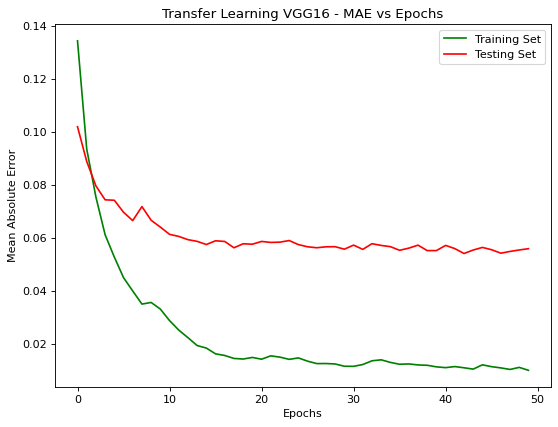

In [24]:
### Plotting Evaluation Function- Mean Absolute Error
plot_scores(train,"Transfer Learning VGG16")

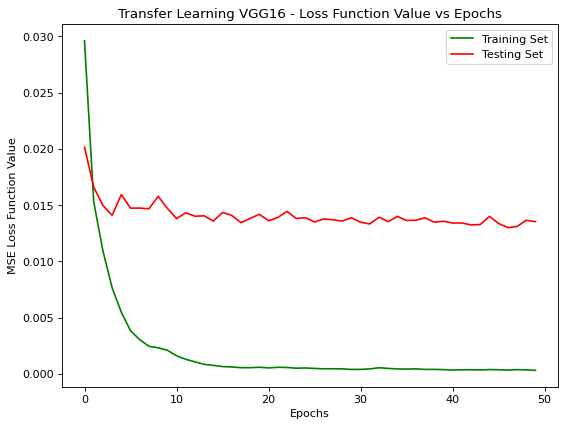

In [25]:
### Plotting Loss Function
plot_loss(train,"Transfer Learning VGG16")

In [26]:
### Predicting output boundary values
y_cnn = model.predict(X_test)

3/3 [==============================] - 0s 147ms/step


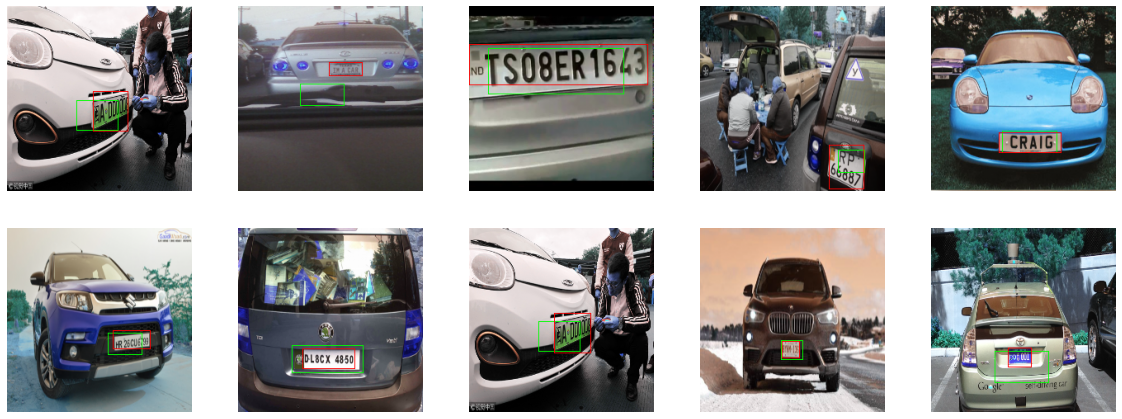

In [27]:
### Plotting the boundaries based on prediction

boundaries(10,y_cnn,y_test,X_test,"/output")